# Introduction

* All the paper and code adopted from [COVID deterioration prediction based on chest X-ray radiographs via MoCo-trained image representations](https://arxiv.org/abs/2101.04909) and [github](https://github.com/facebookresearch/CovidPrognosis) respectively. 
  * Here Single Image Prediction(SIP) method is suitable from the paper, hence its implemented.
  * pretrained models are used for finetuning
  * MoCo adopted from [Momentum Contrast for Unsupervised Visual Representation Learning](https://arxiv.org/abs/1911.05722) paper.

**Self-supervised Learning based on the Momentum Contrast:**

Below figure shows the method MoCo uses to optimize.

MoCo Method:
1. Apply two different augmentation on same image. 
2. Choose the Machine Learning model and input augmented images to models, output will be the encoded features. 
3. Apply the loss function within them and optimize it by gradient descient 
 


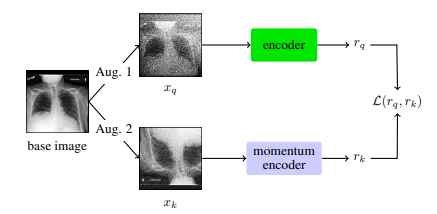




# Importing Libraries

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import early_stopping,ModelCheckpoint
import torch 
from torch import nn 
import torchvision.models as models 
from PIL import Image
import os 
from tqdm import tqdm 
import requests
from pathlib import Path
from sklearn.metrics import roc_auc_score

from typing import Callable, Dict, List, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter


from torchvision import transforms, utils 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader

In [ ]:
class configs:
    N_CLASSES = 11
    TRAIN_CSV = "../input/ranzcr-clip-catheter-line-classification/train.csv"
    TEST_CSV = "../input/ranzcr-clip-catheter-line-classification/sample_submission.csv"
    IMG_DIR = "../input/ranzcr-clip-catheter-line-classification/train/"
    BATCH_SIZE = 64
    NUM_WORKERS = 4
    EPOCHS = 20

# About the dataset

In [ ]:
train_file = pd.read_csv(configs.TRAIN_CSV)
test_file = pd.read_csv(configs.TEST_CSV)
print("train head")
print(train_file.head())
print("-"*100)
print(f"train shape {train_file.shape}, test shape {test_file.shape}")
print(f"train columns {train_file.columns}, \ntest columns {test_file.columns}")

# Creating Dataset Generator

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,image_dir,image_ids,labels=None,transform=None):
    super().__init__()
    self.image_dir = image_dir
    self.image_ids = image_ids
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.image_ids)
  
  def __getitem__(self,idx):
    img_id = str(self.image_ids[idx])
    image = Image.open(os.path.join(self.image_dir,img_id+".jpg"))
    img = self.transform(image) 
    if self.labels is not None:
      labels = self.labels[idx,:]
      return {"image":img,"labels":torch.tensor(labels,dtype=torch.float)}          
    else:
      return {"image":img}

# Image Transformation

In [ ]:
class XRayTransform:
    """XRayTransform base class."""

    def __repr__(self):
        return "XRayTransform: {}".format(self.__class__.__name__)


class HistogramNormalize(XRayTransform):
    """
    Apply histogram normalization.

    Args:
        number_bins: Number of bins to use in histogram.
    """

    def __init__(self, number_bins: int = 256):
        self.number_bins = number_bins

    def __call__(self, sample: Dict) -> Dict:
        image = sample.numpy()

        # get image histogram
        image_histogram, bins = np.histogram(
            image.flatten(), self.number_bins, density=True
        )
        cdf = image_histogram.cumsum()  # cumulative distribution function
        cdf = 255 * cdf / cdf[-1]  # normalize

        # use linear interpolation of cdf to find new pixel values
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
        image_equalized.reshape(image.shape)

        sample = torch.tensor(image_equalized.reshape(image.shape)).to(
            sample
        )

        return sample


class TensorToRGB(XRayTransform):
    """
    Convert Tensor to RGB by replicating channels.

    Args:
        num_output_channels: Number of output channels (3 for RGB).
    """

    def __init__(self, num_output_channels: int = 3):
        self.num_output_channels = num_output_channels

    def __call__(self, sample: Dict) -> Dict:
        expands = list()
        for i in range(sample.ndim):
            if i == 0:
                expands.append(self.num_output_channels)
            else:
                expands.append(-1)
        sample = sample.expand(*expands)

        return sample

train_transform = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
                                        HistogramNormalize(),
                                        TensorToRGB()])
val_transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    HistogramNormalize(),
                                    TensorToRGB()])

# Prepare DataModule

In [ ]:
class XrayDataModule(pl.LightningDataModule):
  def __init__(self,images_path,train_data,val_data,batchsize=32,n_workers=2,train_transform=None,val_transform=None):
    super().__init__()
    train_ids,train_labels= train_data
    val_ids,val_labels = val_data
    self.batchsize = batchsize
    self.n_workers = n_workers
    self.train_dataset = ImageDataset(image_dir=images_path,
                                      image_ids=train_ids,
                                      labels=train_labels,
                                      transform=train_transform)
    self.val_dataset = ImageDataset(image_dir=images_path,
                                    image_ids=val_ids,
                                    labels=val_labels,
                                    transform=train_transform)
  
  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size=self.batchsize,num_workers=self.n_workers,shuffle=True)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size=self.batchsize,num_workers=self.n_workers,shuffle=False)

def get_data():
    dfx = pd.read_csv(configs.TRAIN_CSV)
    train,val = train_test_split(dfx,test_size=0.25)
    train_labels =  train.drop(["StudyInstanceUID","PatientID"],axis=1).values
    val_labels =  val.drop(["StudyInstanceUID","PatientID"],axis=1).values
    train_ids = train.StudyInstanceUID.values
    val_ids = val.StudyInstanceUID.values
    return {"train_data":(train_ids,train_labels),"val_data":(val_ids,val_labels)}


In [ ]:
data = get_data()
data_module = XrayDataModule(images_path=configs.IMG_DIR,
                             train_data=data["train_data"],
                             val_data=data["val_data"],
                             train_transform=train_transform,
                             batchsize=configs.BATCH_SIZE,
                             n_workers=configs.NUM_WORKERS,
                             val_transform=val_transform)

# Data Visualization

In [ ]:
data_loader = data_module.val_dataloader()
data = next(iter(data_loader))
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(100, 100))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
show(utils.make_grid(data["image"][:8],padding=10,normalize=True))

# Creating the Model

In [ ]:
class SipModule(pl.LightningModule):
    
  def __init__(self,arch,num_classes,pretrained_file=None):
    super().__init__()
    self.pretrained_file = str(pretrained_file)
    
    # load the pretrained model
    if pretrained_file is not None:

        self.pretrained_file = str(self.pretrained_file)
        pretrained_dict = torch.load(self.pretrained_file,map_location=self.device)["state_dict"]
        state_dict = {}
        for k, v in pretrained_dict.items():
            if k.startswith("model.encoder_q."):
                k = k.replace("model.encoder_q.", "")
                state_dict[k] = v
        if "model.encoder_q.classifier.weight" in pretrained_dict.keys():
            feature_dim = pretrained_dict[
                "model.encoder_q.classifier.weight"
            ].shape[0]
            in_features = pretrained_dict[
                "model.encoder_q.classifier.weight"
            ].shape[1]

            self.model = models.__dict__[arch](num_classes=feature_dim)
            self.model.load_state_dict(state_dict)
            del self.model.classifier
            self.model.add_module(
                "classifier", torch.nn.Linear(in_features, num_classes)
            )
        else:
            raise RuntimeError("Unrecognized classifier.")
    else:
        self.model = models.__dict__[arch](num_classes=num_classes) 
            
  def forward(self,image):
      return self.model(image) 
  
  def loss(self,output,target):
    return nn.BCEWithLogitsLoss()(output,target)

  def training_step(self,batch,batch_idx):
    output = self(batch["image"])
    target = batch["labels"]
    loss = self.loss(output,target)
    self.log("train_loss",loss,prog_bar=True)
    return loss
  
  def validation_step(self,batch,batch_idx):
    output = self(batch["image"])
    target = batch["labels"]
    loss = self.loss(output,target)
    self.log("val_loss",loss,prog_bar=True)
    return {"output": output, "target": target}
  
  def validation_epoch_end(self,validation_step_outputs):
    output=[]
    target=[]
    for pred in validation_step_outputs:
      output.extend(pred["output"].cpu().detach().numpy())
      target.extend(pred["target"].cpu().detach().numpy())
    self.log("Valid_AUC_SCORE",roc_auc_score(target,output, average="micro"),prog_bar=True) 
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters())
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, configs.EPOCHS) 
    return [optimizer], [scheduler]  
  
model = SipModule(
        arch="DenseNet",
        num_classes = configs.N_CLASSES,
        pretrained_file="../input/sip-moco-pretrained-models/mimic-chexpert_lr_0.01_bs_128_fd_128_qs_65536.pt"
    )

# Training the model

In [ ]:
early_stop_callback = early_stopping.EarlyStopping(monitor='val_loss',verbose=True)
trainer = pl.Trainer(gpus=-1,max_epochs=configs.EPOCHS,callbacks=[early_stop_callback])
#--uncomment below lines to train
#trainer.fit(model, datamodule=data_module)
#trainer.save_checkpoint("two_data_pretrains_dense.ckpt")

# Test data- Inference

Used pretrained models from another notebook for 7 epoch and 0.001 learning rate. 

In [ ]:
test = pd.read_csv(configs.TEST_CSV)
test_ids = test["StudyInstanceUID"].values
test_dataset = ImageDataset(image_dir="../input/ranzcr-clip-catheter-line-classification/test",
                                    image_ids=test_ids,
                                    transform=val_transform)
test_loader = DataLoader(test_dataset,
                        batch_size=64,
                        shuffle=False,
                        num_workers=4)

device = torch.device("cuda")
model = SipModule.load_from_checkpoint("../input/ranzcr-trained/two_data_pretrains_dense.ckpt",arch="DenseNet",num_classes=11)
model.to(device)
model.eval()
model.freeze()
sub = []
with torch.no_grad():
    for data in tqdm(test_loader):
        data = data["image"].to(device)
        out = model(data)
        sub.extend(out.cpu().detach().numpy())
labels = pd.DataFrame(data=sub,columns=test.columns[1:]) 
submit = pd.concat([test.iloc[:,0],labels],axis=1)
submit.to_csv("submission.csv",index=False)
submit.head()